# Aerial-level Analysis - Schools

Part of the iRAP road star rating system includes two attributes for school zones - one for signage/lights for school zones and another for crossing supervisors.

For school signage/lights we can:

1. Find geographic locations of schools (for ex. https://nces.ed.gov/programs/edge/Geographic/SchoolLocations)
1. Find geographic locations of roads around those schools.
1. Seek streetview imagery around the schools using geographic location data (for ex. Google Streetview, etc)
1. Use machine-intelligent techniques to surmise whether there are school zone signs or specialized lights (per region/country as this is typically standardized)
1. Estimate the iRAP code for the "School zone warning" attribute for road segments

An indirect advantage of this might be that roads which are not near schools could be noted to have a code of "4", or not applicable. There may also be a way to determine if there are crossing supervisors though I imagine this will be much more difficult (I've personally noticed they don't stick around all the time so streetview data may not be an accurate depiction).

## To-do

- Gather road lat,lon locations near schools using building or nearby road coordinates.
    - Calculate additional lat/lon points between coords of Shapely linestring coordinates (this should be as straightforward as finding slope, providing a step number, but likely there's a function already available for this).
- Explore parcels futher, i.e. https://wiki.openstreetmap.org/wiki/Parcel

## References

- iRAP
    - Coding Manual - Section "School zone warning" - http://resources.irap.org/Specifications/iRAP_Coding_Manual_Drive_on_Left.pdf
    - Code Upload Specification (code details) - Column "School Zone Warning" - http://resources.irap.org/Specifications/RAP-SR-3-3_Upload_file_specification.xlsx
    - Global KPI Specification - https://www.starratingforschools.org/
        - Star Rating for Schools Coding Specification - https://downloads.starratingforschools.org/Toolkit/SR4S_Coding_Guide.pdf
- School Zones - https://en.wikipedia.org/wiki/School_zone
- OSM
    - Keys / Features
        - https://wiki.openstreetmap.org/wiki/Key:amenity
        - https://wiki.openstreetmap.org/wiki/Education_features
        - https://wiki.openstreetmap.org/wiki/Key:school
    - Parcel note https://wiki.openstreetmap.org/wiki/Parcel
    - API
        - https://wiki.openstreetmap.org/wiki/API_v0.6
        - https://wiki.openstreetmap.org/wiki/Overpass_API
            - Overpass query builder http://overpass-turbo.eu/
    - OSMnx https://github.com/gboeing/osmnx  
- NCES
    - School location data https://nces.ed.gov/programs/edge/Geographic/SchoolLocations#

In [17]:
%matplotlib inline
import os
import time
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import requests
import shapely
import shapely.ops as sp_ops
from IPython.display import Image
from pyproj import Proj, Transformer
from shapely.geometry import LinearRing, LineString

ox.config(log_console=True, log_level=10, use_cache=True)

In [2]:
# https://nces.ed.gov/programs/edge/Geographic/SchoolLocations
# direct link to 2018 post-secondary data: https://nces.ed.gov/programs/edge/data/EDGE_GEOCODE_POSTSEC_1819.zip
# direct link to 2018 public school data: https://nces.ed.gov/programs/edge/data/EDGE_GEOCODE_PUBLICSCH_1819.zip

# download zip file, send content to local file, then unzip
files = [
    "https://nces.ed.gov/programs/edge/data/EDGE_GEOCODE_POSTSECONDARYSCH_1819.zip",
    "https://nces.ed.gov/programs/edge/data/EDGE_GEOCODE_PUBLICSCH_1819.zip",
]

# create a data subdir
if not os.path.isdir("{}/data".format(os.getcwd())):
    os.mkdir("{}/data".format(os.getcwd()))

# download files and unzip into data dir
for file in files:
    if not os.path.isfile("{}/data/{}".format(os.getcwd(), os.path.basename(file))):
        getfile = requests.get(file)
        if getfile.status_code == 200:
            with open(
                "{}/data/{}".format(os.getcwd(), os.path.basename(file)), "wb"
            ) as f:
                f.write(getfile.content)
            with zipfile.ZipFile(
                "{}/data/{}".format(os.getcwd(), os.path.basename(file)), "r"
            ) as zip_ref:
                zip_ref.extractall("{}/data".format(os.getcwd()))

In [3]:
postsec_df = pd.read_excel("data/EDGE_GEOCODE_POSTSECSCH_1819.xlsx")
pub_df = pd.read_excel("data/EDGE_GEOCODE_PUBLICSCH_1819.xlsx")

In [4]:
pub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102176 entries, 0 to 102175
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NCESSCH     102176 non-null  int64  
 1   LEAID       102176 non-null  int64  
 2   NAME        102176 non-null  object 
 3   OPSTFIPS    102176 non-null  int64  
 4   STREET      102175 non-null  object 
 5   CITY        102176 non-null  object 
 6   STATE       102176 non-null  object 
 7   ZIP         102176 non-null  int64  
 8   STFIP       102176 non-null  int64  
 9   CNTY        102176 non-null  int64  
 10  NMCNTY      102176 non-null  object 
 11  LOCALE      102176 non-null  int64  
 12  LAT         102176 non-null  float64
 13  LON         102176 non-null  float64
 14  CBSA        102176 non-null  object 
 15  NMCBSA      102176 non-null  object 
 16  CBSATYPE    102176 non-null  int64  
 17  CSA         102176 non-null  object 
 18  NMCSA       102176 non-null  object 
 19  NE

In [5]:
pub_df.head()

,NCESSCH,LEAID,NAME,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,...,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR
0,10000500870,100005,Albertville Middle School,1,600 E Alabama Ave,Albertville,AL,35950,1,1095,...,"Albertville, AL",2,290,"Huntsville-Decatur-Albertville, AL",N,N,104,01026,01009,2018-2019
1,10000500871,100005,Albertville High School,1,402 E McCord Ave,Albertville,AL,35950,1,1095,...,"Albertville, AL",2,290,"Huntsville-Decatur-Albertville, AL",N,N,104,01026,01009,2018-2019
2,10000500879,100005,Evans Elementary School,1,901 W McKinney Ave,Albertville,AL,35950,1,1095,...,"Albertville, AL",2,290,"Huntsville-Decatur-Albertville, AL",N,N,104,01026,01009,2018-2019
3,10000500889,100005,Albertville Elementary School,1,145 West End Drive,Albertville,AL,35950,1,1095,...,"Albertville, AL",2,290,"Huntsville-Decatur-Albertville, AL",N,N,104,01026,01009,2018-2019
4,10000501616,100005,Big Spring Lake Kindergarten School,1,257 Country Club Rd,Albertville,AL,35951,1,1095,...,"Albertville, AL",2,290,"Huntsville-Decatur-Albertville, AL",N,N,104,01026,01009,2018-2019


In [6]:
sample_latlon = tuple(pub_df.iloc[0][["LAT", "LON"]].to_list())
sample_latlon

(34.260194, -86.206174)

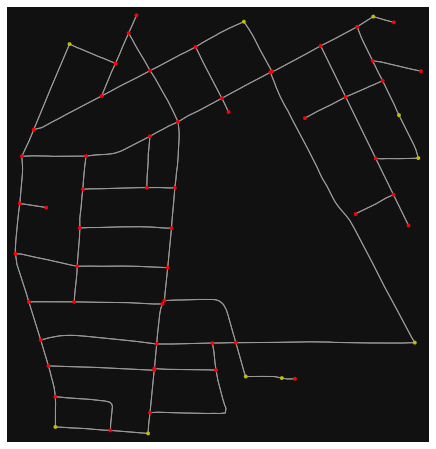

In [7]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = sample_latlon
G = ox.graph_from_point(location_point, network_type="drive", dist=600, simplify=True)
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

We have roads, but perhaps too many roads and those which are not in direct proximity with the school. Attempting to find the building vector space as this may provide better ways to find roads around the school buildings. 

In [8]:
# getting roads from a single latlon point seems like it returns more than we need.
# can we get closer/fewer roads to the school using the amenity polygon details of the school?
poi_df = ox.pois.pois_from_point(sample_latlon, tags={"amenity": True}, dist=600)
poi_df.head()[:1]

/Users/odin/Library/Python/3.7/lib/python/site-packages/osmnx/pois.py:50: UserWarning: The `pois` module has been deprecated and will be removed in a future release. Use the `geometries` module's `geometries_from_point` function instead.
  warnings.warn(msg)


,unique_id,osmid,element_type,amenity,ele,gnis:county_id,gnis:created,gnis:feature_id,gnis:state_id,name,geometry,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,internet_access,nodes
0,node/358953682,358953682,node,school,323,095,12/01/2003,139322,01,Albertville Junior High School,POINT (-86.20610 34.26019),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
poi_df[
    (poi_df["amenity"] == "school") & (poi_df["geometry"].geom_type == "Polygon")
].iloc[0]

unique_id                                                way/78503555
osmid                                                        78503555
element_type                                                      way
amenity                                                        school
ele                                                               319
gnis:county_id                                                    095
gnis:created                                               12/01/2003
gnis:feature_id                                                139321
gnis:state_id                                                      01
name                                          Albertville High School
geometry            POLYGON ((-86.2045567 34.2636728, -86.20716590...
addr:city                                                         NaN
addr:housenumber                                                  NaN
addr:postcode                                                     NaN
addr:state          

In [64]:
poi_df["geometry"].geom_type

0      Point
1      Point
2    Polygon
dtype: object

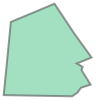

In [10]:
polygon = poi_df.iloc[2]["geometry"]
polygon

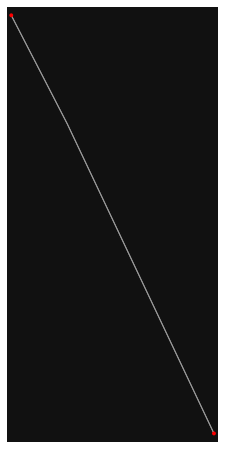

In [11]:
G = ox.graph_from_polygon(polygon=polygon, network_type="drive", truncate_by_edge=True,)

nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

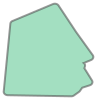

In [12]:
# we don't receive many roads from just the polygon of the school amenity
# so we buffer the polygon with for increased area using the same fxnality osmnx does
# with ox.graph_from_polygon.clean_periphery:
# https://github.com/gboeing/osmnx/blob/8653183bb966cfa826e92f1c95b11efa51f99572/osmnx/graph.py#L415
buffer_dist = 25
poly_proj, crs_utm = ox.projection.project_geometry(polygon)
poly_proj_buff = poly_proj.buffer(buffer_dist)
poly_buff, _ = ox.projection.project_geometry(
    poly_proj_buff, crs=crs_utm, to_latlong=True
)
poly_buff

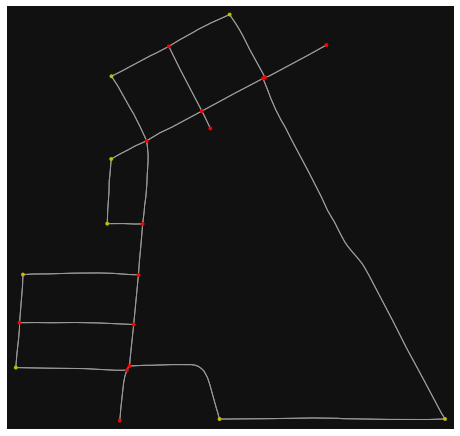

In [13]:
G = ox.graph_from_polygon(
    polygon=poly_buff, network_type="drive", truncate_by_edge=True,
)

nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

In [14]:
roads_df = nx.to_pandas_edgelist(G)
roads_df.head()

,source,target,name,osmid,length,oneway,geometry,highway
0,57491916,57560978,East Alabama Avenue,7841183,110.027,False,NaN,residential
1,57491916,57643195,East Alabama Avenue,7841183,112.473,False,"LINESTRING (-86.207459 34.259944, -86.207437 3...",residential
2,57491916,57658155,Davis Street,7842930,254.561,False,"LINESTRING (-86.207459 34.259944, -86.207649 3...",residential
3,57508649,57566714,East McCord Avenue,7837281,42.501,False,"LINESTRING (-86.205736 34.2628443, -86.2058818...",unclassified
4,57560403,57560407,Marshall Street,7837019,142.447,False,"LINESTRING (-86.208105 34.263878, -86.20787799...",residential


In [48]:
# ref https://gis.stackexchange.com/questions/372912/how-to-densify-linestring-vertices-in-shapely-geopandas
def densify_geometry(line_geometry, step, crs=None):

    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m = line_geometry.length  # get the length

    xy = []  # to store new tuples of coordinates

    # changed to not use casted int for length_m
    for distance_along_old_line in np.arange(0, length_m, step):

        point = line_geometry.interpolate(
            distance_along_old_line
        )  # interpolate a point every step along the old line
        xp, yp = point.x, point.y  # extract the coordinates

        xy.append((xp, yp))  # and store them in xy list

    # new_line=LineString(xy) # Here, we finally create a new line with densified points.

    if (
        crs != None
    ):  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo = gpd.geoseries.GeoSeries(new_line, crs=crs)
        return new_line_geo

    else:
        return xy

In [65]:
# gather road latlon tuples based on road geometry linestring coords
road_latlons = []
lats = []
lons = []
names = []
school = []
for index, row in roads_df[
    ~(roads_df["geometry"].isna()) & ~(roads_df["highway"] == "service")
].iterrows():
    # work in progress
    densified_points = densify_geometry(row["geometry"], step=0.0003)

    road_latlons += densified_points

    lats += [x[1] for x in densified_points]
    lons += [x[0] for x in densified_points]
    names += [row["name"] for x in densified_points]

len(road_latlons)

340

In [66]:
len(lats)

340

In [67]:
lats_lons_df = pd.DataFrame.from_dict(
    {"road_name": names, "lon": lons, "lat": lats, "pair": road_latlons,}
)
lats_lons_df.head()

,road_name,lon,lat,pair
0,East Alabama Avenue,-86.207459,34.259944,"(-86.207459, 34.259944)"
1,East Alabama Avenue,-86.207432,34.260243,"(-86.20743227750025, 34.26024279412285)"
2,East Alabama Avenue,-86.207399,34.260541,"(-86.20739859354683, 34.260540897110566)"
3,East Alabama Avenue,-86.207369,34.260839,"(-86.20736905771024, 34.26083943818038)"
4,Davis Street,-86.207459,34.259944,"(-86.207459, 34.259944)"


<AxesSubplot:title={'center':'Road Lat/Lon Around School'}, xlabel='lon', ylabel='lat'>

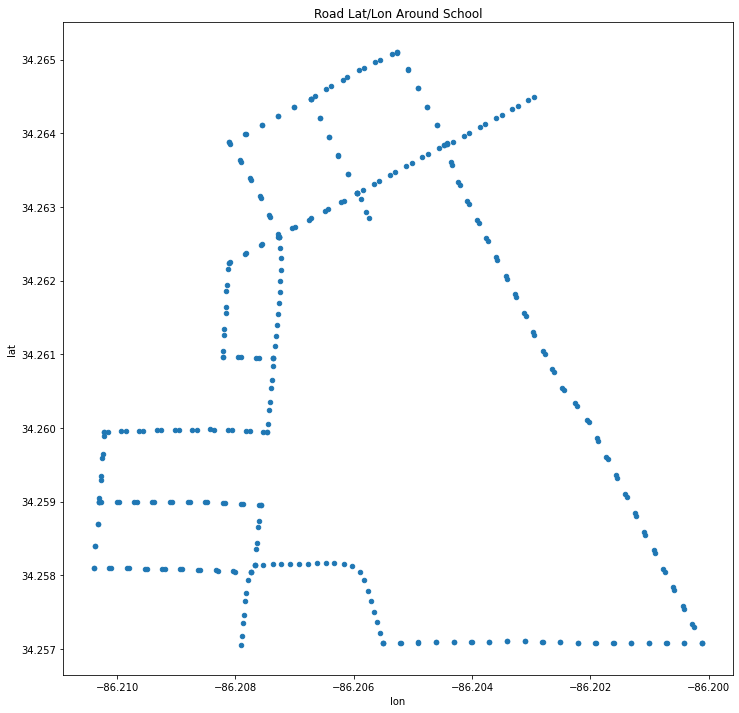

In [68]:
lats_lons_df[["lat", "lon"]].plot(
    kind="scatter",
    x="lon",
    y="lat",
    figsize=(12, 12),
    title="Road Lat/Lon Around School",
)

## School Amenity Zone Road Points (attempt to automate the above with limited subset)

In [77]:
def buffer_polygon(
    polygon: shapely.geometry.polygon.Polygon, buffer_dist: int = 25
) -> shapely.geometry.polygon.Polygon:
    """
    We don't receive many roads from just the polygon of the school amenity
    so we buffer the polygon for increased area using the same fxnality osmnx does
    with ox.graph_from_polygon.clean_periphery:
    https://github.com/gboeing/osmnx/blob/8653183bb966cfa826e92f1c95b11efa51f99572/osmnx/graph.py#L415

    buffer_dist == amount to buffer the polygon in meters(?)
    """

    poly_proj, crs_utm = ox.projection.project_geometry(polygon)
    poly_proj_buff = poly_proj.buffer(buffer_dist)
    poly_buff, _ = ox.projection.project_geometry(
        poly_proj_buff, crs=crs_utm, to_latlong=True
    )
    return poly_buff


# ref https://gis.stackexchange.com/questions/372912/how-to-densify-linestring-vertices-in-shapely-geopandas
def densify_geometry(line_geometry, step, crs=None):

    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m = line_geometry.length  # get the length

    xy = []  # to store new tuples of coordinates

    # changed to not use casted int for length_m
    for distance_along_old_line in np.arange(0, length_m, step):

        point = line_geometry.interpolate(
            distance_along_old_line
        )  # interpolate a point every step along the old line
        xp, yp = point.x, point.y  # extract the coordinates

        xy.append((xp, yp))  # and store them in xy list

    # new_line=LineString(xy) # Here, we finally create a new line with densified points.

    if (
        crs != None
    ):  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo = gpd.geoseries.GeoSeries(new_line, crs=crs)
        return new_line_geo

    else:
        return xy


def gather_road_points_around_amenity(
    lat: float, lon: float, amenity_types: list
) -> pd.DataFrame:
    # single lat/lon location of the school
    point = tuple([lat, lon])

    # find amenities near point
    poi_df = ox.geometries.geometries_from_point(
        point, tags={"amenity": True}, dist=600
    )

    # limit results to the first amenity with a polygon geometry type
    # there's a better way, but the hope here is that there aren't too many other overlapping polygons
    school_poi = poi_df[
        (poi_df["amenity"].isin(amenity_types))
        & (poi_df["geometry"].geom_type == "Polygon")
    ].iloc[0]

    # loop for buffer range of amenity polygon to make sure we receive roads back without errors
    for x in range(25, 80, 3):
        try:
            # buffer/inflate the geometry polygon to encompass nearby roads with next steps
            buffered_school_poi_geometry = buffer_polygon(
                polygon=school_poi["geometry"], buffer_dist=x
            )

            # get roads graph based on buffered polygon
            school_roads_graph = ox.graph_from_polygon(
                polygon=buffered_school_poi_geometry,
                network_type="drive",
                truncate_by_edge=True,
            )

            # if we're able to run without a valueerror being emitted, break loop
            break

        # if we reach a value error, continue the try's until we don't error
        except ValueError:
            # print("Failed with buffered polygon of dist {}, trying again with greater buffer.".format(x))
            continue

    # extract roads pandas edgelist from school roads nx graph
    roads_df = nx.to_pandas_edgelist(school_roads_graph)

    # gather road latlon tuples based on road geometry linestring coords
    lats = []
    lons = []
    road_names = []
    road_lengths = []
    bearings = []
    for index, rrow in roads_df[
        ~(roads_df["geometry"].isna()) & ~(roads_df["highway"] == "service")
    ].iterrows():

        densified_points = densify_geometry(rrow["geometry"], step=0.0002)

        if len(densified_points) > 1:
            lats += [x[1] for x in densified_points]
            lons += [x[0] for x in densified_points]
            road_names += [rrow["name"] for x in densified_points]
            road_lengths += [rrow["length"] for x in densified_points]

            for x in range(0, len(densified_points)):

                # calculate bearings of the road
                if x == 0:
                    # if we're at the beginning of the road linestring,
                    # reverse the bearing source and targ to keep uniform bearings for data
                    bearing = ox.bearing.get_bearing(
                        densified_points[x + 1], densified_points[x]
                    )
                else:
                    bearing = ox.bearing.get_bearing(
                        densified_points[x], densified_points[x - 1]
                    )

                bearings.append(bearing)

    # create a dataframe to encapsulate data gathered above
    school_road_points_df = pd.DataFrame.from_dict(
        {
            "road_name": road_names,
            "lon": lons,
            "lat": lats,
            "road_length": road_lengths,
            "bearing": bearings,
        }
    )

    return school_road_points_df


df_list = []
for index, row in pub_df[~(pub_df["LAT"].isna()) & ~(pub_df["LON"].isna())].iterrows():

    # limit results to arbitary small number
    if index > 5:
        break

    print("Processing data for: {}".format(row["NAME"]))

    road_points_df = gather_road_points_around_amenity(
        lat=row["LAT"],
        lon=row["LON"],
        amenity_types=["school", "kindergarten", "preeschool"],
    )

    # append school details from source data for road coordinates
    road_points_df["school_NCESSCH"] = row["NCESSCH"]
    road_points_df["school_LEAID"] = row["LEAID"]
    road_points_df["school_street"] = row["STREET"]
    road_points_df["school_city"] = row["CITY"]
    road_points_df["school_state"] = row["STATE"]
    road_points_df["school_country"] = "USA"
    road_points_df["school"] = row["NAME"]
    road_points_df["school_lat"] = row["LAT"]
    road_points_df["school_lon"] = row["LON"]

    # append the dataframe to a list for later concatenation
    df_list.append(road_points_df)

Processing data for: Albertville Middle School
Processing data for: Albertville High School
Processing data for: Evans Elementary School
Processing data for: Albertville Elementary School
Processing data for: Big Spring Lake Kindergarten School
Processing data for: Albertville Primary School


In [79]:
merged_df = pd.concat(df_list)
merged_df.head(10)

,road_name,lon,lat,road_length,bearing,school_NCESSCH,school_LEAID,school_street,school_city,school_state,school_country,school,school_lat,school_lon
0,East Alabama Avenue,-86.207459,34.259944,112.473,217.692586,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
1,East Alabama Avenue,-86.207442,34.260143,112.473,217.692586,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
2,East Alabama Avenue,-86.207421,34.260342,112.473,212.197864,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
3,East Alabama Avenue,-86.207399,34.260541,112.473,210.343839,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
4,East Alabama Avenue,-86.207379,34.260740,112.473,213.672736,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
5,East Alabama Avenue,-86.207359,34.260939,112.473,213.953386,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
6,Davis Street,-86.207459,34.259944,254.561,359.912967,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
7,Davis Street,-86.207659,34.259949,254.561,359.912967,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
8,Davis Street,-86.207859,34.259960,254.561,359.774431,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174
9,Davis Street,-86.208058,34.259972,254.561,359.774443,10000500870,100005,600 E Alabama Ave,Albertville,AL,USA,Albertville Middle School,34.260194,-86.206174


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   road_name       910 non-null    object 
 1   lon             1042 non-null   float64
 2   lat             1042 non-null   float64
 3   road_length     1042 non-null   float64
 4   bearing         1042 non-null   float64
 5   school_NCESSCH  1042 non-null   int64  
 6   school_LEAID    1042 non-null   int64  
 7   school_street   1042 non-null   object 
 8   school_city     1042 non-null   object 
 9   school_state    1042 non-null   object 
 10  school_country  1042 non-null   object 
 11  school          1042 non-null   object 
 12  school_lat      1042 non-null   float64
 13  school_lon      1042 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 122.1+ KB


In [15]:
list(merged_df.columns)

['road_name',
 'lon',
 'lat',
 'road_length',
 'bearing',
 'school_NCESSCH',
 'school_LEAID',
 'school_street',
 'school_city',
 'school_state',
 'school_country',
 'school',
 'school_lat',
 'school_lon']

In [81]:
merged_df[
    [
        "school_NCESSCH",
        "school_LEAID",
        "school_street",
        "school_city",
        "school_state",
        "school_country",
        "school",
        "school_lat",
        "school_lon",
        "road_name",
        "lat",
        "lon",
        "road_length",
        "bearing",
    ]
].to_csv("../data/school_roads-sample.csv", index=False)

## School Building Coordinate Analysis

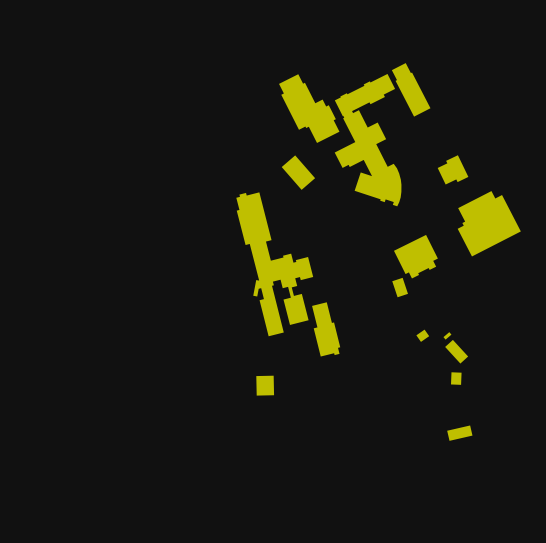

In [15]:
# can we get some details about the buildings and would this provide better road coordinates than above?

img_folder = "images"
extension = "png"
size = 240

tags = {"building": True}
gdf = ox.geometries_from_point(sample_latlon, tags, dist=300)
gdf_proj = ox.project_gdf(gdf)
bbox = ox.utils_geo.bbox_from_point(point=location_point, dist=350, project_utm=True)
fp = f"./{img_folder}/school_buildings.{extension}"
fig, ax = ox.plot_footprints(
    gdf_proj,
    bbox=bbox,
    color="y",
    filepath=fp,
    dpi=90,
    save=True,
    show=False,
    close=True,
)
Image(fp, height=size, width=size)

In [16]:
gdf.head()

,unique_id,osmid,element_type,nodes,building,geometry
0,way/780212348,780212348,way,"[7285029563, 7285029564, 7285029565, 728502956...",school,"POLYGON ((-86.20642 34.25897, -86.20642 34.258..."
1,way/780212350,780212350,way,"[7285029571, 7285029572, 7285029573, 728502957...",school,"POLYGON ((-86.20645 34.25991, -86.20641 34.260..."
2,way/780212351,780212351,way,"[7285084519, 7285084520, 7285084521, 728508452...",school,"POLYGON ((-86.20551 34.25919, -86.20561 34.259..."
3,way/780212356,780212356,way,"[7285084578, 7285084579, 7285084580, 728508458...",school,"POLYGON ((-86.20447 34.26042, -86.20402 34.260..."
4,way/780212362,780212362,way,"[7285084631, 7285402892, 7285084632, 728508463...",school,"POLYGON ((-86.20604 34.26141, -86.20589 34.261..."


In [17]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   unique_id     16 non-null     object  
 1   osmid         16 non-null     int64   
 2   element_type  16 non-null     object  
 3   nodes         16 non-null     object  
 4   building      16 non-null     object  
 5   geometry      16 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 896.0+ bytes


In [18]:
gdf["geometry"].bounds

,minx,miny,maxx,maxy
0,-86.206421,34.258744,-86.206173,34.258974
1,-86.206682,34.259435,-86.205610,34.261116
2,-86.205629,34.259194,-86.205237,34.259826
3,-86.204472,34.260097,-86.203855,34.260603
4,-86.206040,34.261141,-86.205572,34.261544
5,-86.203744,34.258198,-86.203389,34.258376
6,-86.203685,34.258850,-86.203535,34.258998
7,-86.203763,34.259099,-86.203441,34.259376
8,-86.204166,34.259355,-86.203986,34.259498
9,-86.203785,34.259380,-86.203673,34.259467


In [ ]:
# gather roads near boundaries provided
# attempting to further constrain the roads
# (we don't want to analyze roads too far away from the school)
graphs = []
for index, row in gdf["geometry"].bounds.iterrows():
    latlon_min = tuple([row["miny"], row["minx"]])
    latlon_max = tuple([row["maxy"], row["maxx"]])
    G_min = ox.graph_from_point(
        latlon_min, network_type="drive", dist=300, simplify=True
    )
    G_max = ox.graph_from_point(
        latlon_max, network_type="drive", dist=300, simplify=True
    )
    graphs.append(G_min)
    graphs.append(G_max)

# combine all of our collected graphs
combined = nx.compose_all(graphs)

In [ ]:
nc = [
    "r" if ox.simplification._is_endpoint(combined, node) else "y"
    for node in combined.nodes()
]
fig, ax = ox.plot_graph(combined, node_color=nc)

In [ ]:
roads_df = nx.to_pandas_edgelist(combined)
roads_df.info()

In [37]:
roads_df.head()

,source,target,ref,geometry,highway,area,service,oneway,osmid,name,length
0,57491916,57560978,NaN,NaN,residential,NaN,NaN,False,7841183,East Alabama Avenue,110.027
1,57491916,57491924,NaN,"LINESTRING (-86.207459 34.259944, -86.20737099...",service,NaN,NaN,False,7833311,NaN,76.503
2,57491916,57643195,NaN,"LINESTRING (-86.207459 34.259944, -86.207437 3...",residential,NaN,NaN,False,7841183,East Alabama Avenue,112.473
3,57491924,57491963,NaN,"LINESTRING (-86.20664600000001 34.259999, -86....",service,NaN,NaN,False,7833311,NaN,181.732
4,57491924,57491916,NaN,"LINESTRING (-86.20664600000001 34.259999, -86....",service,NaN,NaN,False,7833311,NaN,76.503


In [38]:
roads_df["highway"].unique()

array(['residential', 'service', 'tertiary', 'unclassified', 'secondary'],
      dtype=object)

In [39]:
roads_df["name"].unique()

array(['East Alabama Avenue', nan, 'Noblitt Street', 'College Street',
       'Teal Street', 'Elm Street', 'Draper Street', 'Dora Street',
       'East McCord Avenue', 'Jackson Street', 'Baltimore Avenue',
       'Eunice Street', 'West Lane Street', 'Boyd Street',
       'McDonald Avenue', 'Marshall Street', 'Albert Street',
       'East Main Street'], dtype=object)

In [40]:
roads_df["geometry"]

0                                                    NaN
1      LINESTRING (-86.207459 34.259944, -86.20737099...
2      LINESTRING (-86.207459 34.259944, -86.207437 3...
3      LINESTRING (-86.20664600000001 34.259999, -86....
4      LINESTRING (-86.20664600000001 34.259999, -86....
                             ...                        
148    LINESTRING (-86.201082 34.263625, -86.200727 3...
149    LINESTRING (-86.20000400000001 34.261694, -86....
150    LINESTRING (-86.20000400000001 34.261694, -86....
151    LINESTRING (-86.20058899999999 34.262767, -86....
152    LINESTRING (-86.20058899999999 34.262767, -86....
Name: geometry, Length: 153, dtype: object

In [41]:
roads_df["geometry"].iloc[1].coords.xy

(array('d', [-86.207459, -86.207371, -86.207209, -86.207039, -86.206785, -86.206646]),
 array('d', [34.259944, 34.259946, 34.259929, 34.259924, 34.25994, 34.259999]))

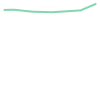

In [42]:
roads_df["geometry"].iloc[1]

In [43]:
roads_df["geometry"].iloc[2].length

0.001013103652424786

In [44]:
roads_df["geometry"].iloc[1].interpolate(6).coords[0]

(-86.206646, 34.259999)

In [45]:
# gather road latlon tuples based on road geometry linestring coords
road_latlons = []
for x in range(0, len(roads_df["geometry"].iloc[1].coords.xy[1])):
    road_latlons.append(
        tuple(
            [
                roads_df["geometry"].iloc[1].coords.xy[1][x],
                roads_df["geometry"].iloc[1].coords.xy[0][x],
            ]
        )
    )
road_latlons

[(34.259944, -86.207459),
 (34.259946, -86.207371),
 (34.259929, -86.207209),
 (34.259924, -86.207039),
 (34.25994, -86.206785),
 (34.259999, -86.206646)]

In [46]:
# gather road latlon tuples based on road geometry linestring coords
road_latlons = []
lats = []
lons = []
names = []
school = []
for index, row in roads_df[
    ~(roads_df["geometry"].isna()) & ~(roads_df["highway"] == "service")
].iterrows():
    for x in range(0, len(row["geometry"].coords.xy[1])):
        road_latlons.append(
            tuple([row["geometry"].coords.xy[1][x], row["geometry"].coords.xy[0][x]])
        )
        lats.append(row["geometry"].coords.xy[1][x])
        lons.append(row["geometry"].coords.xy[0][x])
        names.append(row["name"])
        school.append(pub_df.iloc[0]["NAME"])

len(road_latlons)

408

In [47]:
lats_lons_df = pd.DataFrame.from_dict(
    {
        "school": school,
        "road_name": names,
        "lon": lons,
        "lat": lats,
        "pair": road_latlons,
    }
)
lats_lons_df.head()

,school,road_name,lon,lat,pair
0,Albertville Middle School,East Alabama Avenue,-86.207459,34.259944,"(34.259944, -86.207459)"
1,Albertville Middle School,East Alabama Avenue,-86.207437,34.260201,"(34.260201, -86.207437)"
2,Albertville Middle School,East Alabama Avenue,-86.207397,34.260555,"(34.260555, -86.207397)"
3,Albertville Middle School,East Alabama Avenue,-86.207358,34.260952,"(34.260952, -86.207358)"
4,Albertville Middle School,East Alabama Avenue,-86.207573,34.258959,"(34.258959, -86.207573)"


<AxesSubplot:title={'center':'Road Lat/Lon Around School'}, xlabel='lon', ylabel='lat'>

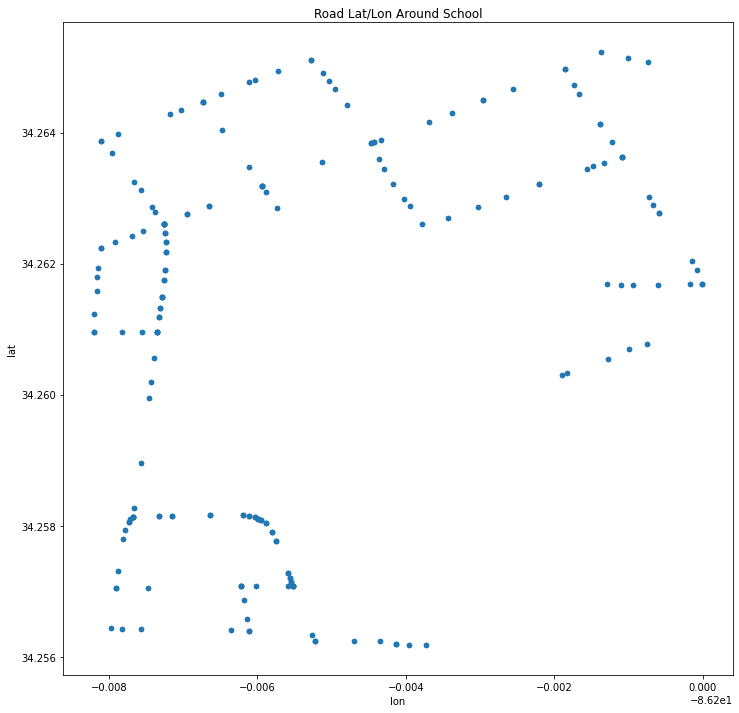

In [48]:
lats_lons_df[["lat", "lon"]].plot(
    kind="scatter",
    x="lon",
    y="lat",
    figsize=(12, 12),
    title="Road Lat/Lon Around School",
)